In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import cvxpy as cp
import networkx as nx
from sklearn.linear_model import lasso_path, Lasso
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from random import shuffle

In [2]:
us_swap_df = pd.read_csv("USSwap.csv")
us_swap_df['Date'] = pd.to_datetime(us_swap_df['Date'])
us_swap_df.set_index('Date', inplace=True)
us_swap_df.fillna(method="ffill", inplace=True)

# demeaned to match the assumption, as LASSO does not need
us_swap_df_demeaned = us_swap_df - us_swap_df.mean(axis=0)

In [3]:
us_swap_df_shifted = us_swap_df_demeaned.shift(1).dropna()

## LASSO estimate of $A$

In [4]:
alpha_candidate = []
for instr in us_swap_df_shifted.columns:
    dep_var = us_swap_df_demeaned[instr].loc[us_swap_df_shifted.index]
    endog_var = us_swap_df_shifted
    alphas_lasso, coefs_lasso, _ = lasso_path(endog_var, dep_var, eps=1e-4)
    non_zeros = np.count_nonzero(coefs_lasso, axis=0)
    best_alpha = alphas_lasso[((non_zeros <= 6) & (non_zeros >= 4)).argmax().min()]
    alpha_candidate.append(best_alpha)
    
print(np.array(alpha_candidate).max())
print(np.array(alpha_candidate).min())

0.005566343201245493
0.0001333368280870626


In [5]:
alpha1 = np.array(alpha_candidate).max()
alpha2 = np.array(alpha_candidate).min()

In [6]:
for alpha_ in np.logspace(-3, -4.2, 100):
    coef_list = []
    for instr in us_swap_df_shifted.columns:
        dep_var = us_swap_df_demeaned[instr].loc[us_swap_df_shifted.index]
        endog_var = us_swap_df_shifted
        lasso_model = Lasso(alpha=alpha_, fit_intercept=False, max_iter=10000)
        coefs_lasso = lasso_model.fit(endog_var, dep_var).coef_
        coef_list.append(coefs_lasso)
        
    Ahat = np.vstack(tuple(coef_list))
    non_zeros = np.count_nonzero(Ahat)
    
    if non_zeros == 40:
        print(alpha_)
        break
        
Ahat

0.00016758780942343246


array([[ 9.49322503e-01,  8.74181802e-02, -0.00000000e+00,
        -2.52104544e-02, -1.20459592e-02, -3.87917279e-03,
        -0.00000000e+00, -0.00000000e+00],
       [ 4.44063065e-02,  8.83379898e-01,  7.86708937e-02,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -1.01664690e-02],
       [-5.33757473e-02,  3.49064602e-01,  4.36122970e-01,
         1.99617259e-01,  7.19642544e-02,  0.00000000e+00,
        -0.00000000e+00, -2.81803023e-03],
       [-2.18709585e-02,  0.00000000e+00,  4.10986410e-01,
         3.26984937e-01,  1.87319916e-01,  9.54720910e-02,
         0.00000000e+00, -0.00000000e+00],
       [-4.61488752e-03, -0.00000000e+00,  5.97363862e-03,
         3.44543296e-01,  4.23081498e-01,  2.29765053e-01,
         0.00000000e+00,  0.00000000e+00],
       [-1.14881531e-02, -0.00000000e+00,  0.00000000e+00,
         3.42718709e-03,  3.41652582e-01,  4.00938902e-01,
         2.23306819e-01,  4.47676413e-02],
       [-7.94200001e-03, -0.000000

## Graphical LASSO estimate of $\Gamma$

In [7]:
us_swap_df_demeaned.shape

(2087, 8)

In [8]:
edge_model = GraphicalLasso(alpha=1.5, max_iter=1000)

edge_model.fit(us_swap_df_demeaned)
edge_model.precision_

array([[ 0.46774596, -0.16454162, -0.14043265, -0.12035352, -0.10729117,
        -0.08248577, -0.03400646, -0.        ],
       [-0.16454162,  0.52831119, -0.11221888, -0.08888046, -0.07119991,
        -0.03561526, -0.        , -0.        ],
       [-0.14043265, -0.11221888,  0.58691754, -0.05090987, -0.02722771,
        -0.        , -0.        , -0.        ],
       [-0.12035352, -0.08888046, -0.05090987,  0.64966714, -0.        ,
        -0.        , -0.        , -0.        ],
       [-0.10729117, -0.07119991, -0.02722771, -0.        ,  0.71192096,
        -0.        , -0.        , -0.        ],
       [-0.08248577, -0.03561526, -0.        , -0.        , -0.        ,
         0.84517639, -0.        , -0.        ],
       [-0.03400646, -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  1.04477744, -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        ,  1.74443359]])

In [9]:
gamma = np.linalg.inv(edge_model.precision_)

In [10]:
gamma

array([[3.67604229, 1.73486723, 1.3361408 , 1.02305187, 0.77861079,
        0.43187305, 0.11965149, 0.        ],
       [1.73486723, 2.89348263, 1.06523877, 0.80072175, 0.59157642,
        0.29124569, 0.05646819, 0.        ],
       [1.3361408 , 1.06523877, 2.295261  , 0.57312365, 0.39568399,
        0.17529045, 0.04349004, 0.        ],
       [1.02305187, 0.80072175, 0.57312365, 1.88323218, 0.25618096,
        0.13358765, 0.03329931, 0.        ],
       [0.77861079, 0.59157642, 0.39568399, 0.25618096, 1.59628932,
        0.10091793, 0.025343  , 0.        ],
       [0.43187305, 0.29124569, 0.17529045, 0.13358765, 0.10091793,
        1.23760695, 0.01405703, 0.        ],
       [0.11965149, 0.05646819, 0.04349004, 0.03329931, 0.025343  ,
        0.01405703, 0.96103619, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.57325197]])

In [11]:
edge_model.covariance_

array([[3.67616443, 1.73489974, 1.33618145, 1.02308213, 0.778634  ,
        0.43188635, 0.11965546, 0.        ],
       [1.73489974, 2.89348782, 1.06524666, 0.8007291 , 0.59158214,
        0.29124909, 0.05646925, 0.        ],
       [1.33618145, 1.06524666, 2.29526614, 0.57313266, 0.3956911 ,
        0.17529475, 0.04349137, 0.        ],
       [1.02308213, 0.8007291 , 0.57313266, 1.88324165, 0.2561866 ,
        0.13359091, 0.0333003 , 0.        ],
       [0.778634  , 0.59158214, 0.3956911 , 0.2561866 , 1.59629455,
        0.10092044, 0.02534376, 0.        ],
       [0.43188635, 0.29124909, 0.17529475, 0.13359091, 0.10092044,
        1.23760779, 0.01405747, 0.        ],
       [0.11965546, 0.05646925, 0.04349137, 0.0333003 , 0.02534376,
        0.01405747, 0.96103632, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.57325197]])

In [12]:
pd.DataFrame(edge_model.precision_)

,0,1,2,3,4,5,6,7
0,0.467746,-0.164542,-0.140433,-0.120354,-0.107291,-0.082486,-0.034006,-0.000000
1,-0.164542,0.528311,-0.112219,-0.088880,-0.071200,-0.035615,-0.000000,-0.000000
2,-0.140433,-0.112219,0.586918,-0.050910,-0.027228,-0.000000,-0.000000,-0.000000
3,-0.120354,-0.088880,-0.050910,0.649667,-0.000000,-0.000000,-0.000000,-0.000000
4,-0.107291,-0.071200,-0.027228,-0.000000,0.711921,-0.000000,-0.000000,-0.000000
5,-0.082486,-0.035615,-0.000000,-0.000000,-0.000000,0.845176,-0.000000,-0.000000
6,-0.034006,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.044777,-0.000000
7,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.744434


In [13]:
graph = nx.from_numpy_array(edge_model.precision_)

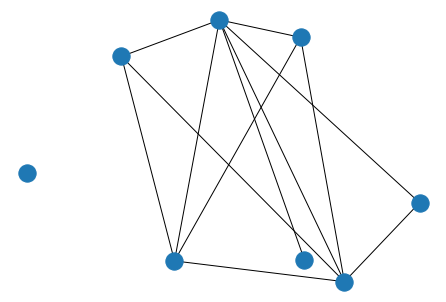

In [14]:
nx.draw(graph)

## Greedy algorithm

In [15]:
A = Ahat.T @ gamma @ Ahat
B = gamma

In [16]:
test_eigh = scipy.linalg.eigh(A, B)

In [17]:
test_eigh

(array([5.11103618e-04, 3.07906734e-02, 2.01592290e-01, 4.07817956e-01,
        6.77035465e-01, 9.21842894e-01, 1.07290046e+00, 1.24397484e+00]),
 array([[ 3.58545307e-04,  8.45226416e-03, -4.15567747e-02,
          1.07533244e-01,  2.64890461e-01, -6.05301311e-01,
         -1.32148158e-01, -1.90854310e-02],
        [ 1.07683549e-02,  4.41107484e-02,  1.73925108e-01,
         -2.54125898e-01, -3.11657487e-01,  1.07751729e-01,
         -5.00538280e-02, -5.65838626e-01],
        [-5.73027269e-02, -3.55106185e-01, -5.45751012e-01,
          2.74250370e-01, -6.05750583e-02,  2.76636811e-01,
          5.18258160e-02, -3.99113989e-02],
        [ 2.36565135e-01,  6.11494332e-01, -2.13541354e-02,
          3.27671196e-01,  1.16924224e-01,  2.96882539e-01,
          9.26641203e-02,  3.94612405e-02],
        [-5.31363929e-01, -1.12868356e-01,  4.03219311e-01,
          1.96041538e-01,  3.25034855e-01,  2.88973142e-01,
          1.63228871e-01,  4.37862332e-03],
        [ 6.06760995e-01, -3.63409

In [18]:
test_eigh[1][-1, :]

array([ 0.00657944, -0.01185494,  0.07080134,  0.22057268, -0.43277756,
       -0.40706941,  1.15637404, -0.01953948])

In [19]:
col_row_list = []
candidate_list = set(range(A.shape[0]))
designated_k = 5
for num in range(designated_k):
    # num is the length of support we're considering
    print(col_row_list)
    max_gen_eig_ratio = np.NINF
    seq = list(candidate_list)
    shuffle(seq)
    for support in seq:
        cand = col_row_list + [support]
        left_matrix = A[cand, :][:, cand]
        print(left_matrix)
        right_matrix = B[cand, :][:, cand]
        print(right_matrix)
        if len(cand) == 1:
            left_matrix = left_matrix.reshape(-1, 1)
            right_matrix = right_matrix.reshape(-1, 1)

        eigval, eigvec = scipy.linalg.eigh(left_matrix, right_matrix)
        
        x = np.zeros((A.shape[0], ))
        x[cand] = eigvec[-1, :]
        x = x.reshape(-1, 1)
        
        gen_eig_ratio = np.squeeze((x.T @ A @ x) / (x.T @ B @ x))
        if gen_eig_ratio > max_gen_eig_ratio:
            max_gen_eig_ratio = gen_eig_ratio
            cur_support = support
    col_row_list.append(cur_support)
    candidate_list.remove(cur_support)
        
print(col_row_list)

[]
[[0.62849321]]
[[1.88323218]]
[[0.570341]]
[[0.57325197]]
[[1.10683327]]
[[2.295261]]
[[3.27138176]]
[[3.67604229]]
[[3.57215433]]
[[2.89348263]]
[[0.40092797]]
[[0.96103619]]
[[0.41550901]]
[[1.23760695]]
[[0.62531508]]
[[1.59628932]]
[1]
[[3.57215433 1.46706406]
 [1.46706406 1.10683327]]
[[2.89348263 1.06523877]
 [1.06523877 2.295261  ]]
[[3.57215433 0.7225919 ]
 [0.7225919  0.62531508]]
[[2.89348263 0.59157642]
 [0.59157642 1.59628932]]
[[3.57215433 0.89085727]
 [0.89085727 0.62849321]]
[[2.89348263 0.80072175]
 [0.80072175 1.88323218]]
[[3.57215433 2.21038034]
 [2.21038034 3.27138176]]
[[2.89348263 1.73486723]
 [1.73486723 3.67604229]]
[[3.57215433 0.12415391]
 [0.12415391 0.40092797]]
[[2.89348263 0.05646819]
 [0.05646819 0.96103619]]
[[ 3.57215433 -0.00923298]
 [-0.00923298  0.570341  ]]
[[2.89348263 0.        ]
 [0.         0.57325197]]
[[3.57215433 0.4169374 ]
 [0.4169374  0.41550901]]
[[2.89348263 0.29124569]
 [0.29124569 1.23760695]]
[1, 2]
[[ 3.57215433e+00  1.46706406e+0

## SDP

In [20]:
X_dim = B.shape[0]
X = cp.Variable((X_dim, X_dim), symmetric=True)

In [21]:
card = 8

constraints = [
    cp.sum(cp.abs(X)) <= card * cp.trace(X),
    cp.trace(X) >= 0,
    cp.trace(B @ X) == 1,
    X >> 0
]

In [22]:
prob = cp.Problem(cp.Maximize(cp.trace(A @ X)), constraints)
prob.solve()

1.2439727261594498

In [23]:
for variable in prob.variables():
    print(variable.name(), variable.value)

var0 [[ 3.64035702e-04  1.07988011e-02  7.61897135e-04 -7.53039947e-04
  -8.34484871e-05  6.66371797e-04  1.00111861e-03  3.72208993e-04]
 [ 1.07988011e-02  3.20170866e-01  2.25855729e-02 -2.23267810e-02
  -2.47623357e-03  1.97545277e-02  2.96798935e-02  1.10357343e-02]
 [ 7.61897135e-04  2.25855729e-02  1.59319975e-03 -1.57482550e-03
  -1.74481221e-04  1.39366071e-03  2.09364838e-03  7.78465168e-04]
 [-7.53039947e-04 -2.23267810e-02 -1.57482550e-03  1.55702893e-03
   1.72994814e-04 -1.37744637e-03 -2.06969742e-03 -7.69581625e-04]
 [-8.34484871e-05 -2.47623357e-03 -1.74481221e-04  1.72994814e-04
   1.91713890e-05 -1.52616920e-04 -2.29524453e-04 -8.53072520e-05]
 [ 6.66371797e-04  1.97545277e-02  1.39366071e-03 -1.37744637e-03
  -1.52616920e-04  1.21874525e-03  1.83125646e-03  6.81000957e-04]
 [ 1.00111861e-03  2.96798935e-02  2.09364838e-03 -2.06969742e-03
  -2.29524453e-04  1.83125646e-03  2.75103477e-03  1.02312697e-03]
 [ 3.72208993e-04  1.10357343e-02  7.78465168e-04 -7.69581625e-0

In [24]:
optimized_Y = prob.variables()[0].value
trace_BX = 1 / np.trace(optimized_Y)
matrix_X = optimized_Y / trace_BX

In [25]:
trace_BX

3.0482695658265957

In [26]:
np.sum(np.abs(optimized_Y))

0.6014615028432359

In [27]:
matrix_X

array([[ 1.19423723e-04,  3.54260044e-03,  2.49944147e-04,
        -2.47038502e-04, -2.73756914e-05,  2.18606584e-04,
         3.28421941e-04,  1.22105012e-04],
       [ 3.54260044e-03,  1.05033646e-01,  7.40930958e-03,
        -7.32441162e-03, -8.12340745e-04,  6.48057111e-03,
         9.73663676e-03,  3.62032756e-03],
       [ 2.49944147e-04,  7.40930958e-03,  5.22657105e-04,
        -5.16629342e-04, -5.72394327e-05,  4.57197332e-04,
         6.86831769e-04,  2.55379372e-04],
       [-2.47038502e-04, -7.32441162e-03, -5.16629342e-04,
         5.10791088e-04,  5.67518095e-05, -4.51878135e-04,
        -6.78974537e-04, -2.52465082e-04],
       [-2.73756914e-05, -8.12340745e-04, -5.72394327e-05,
         5.67518095e-05,  6.28926955e-06, -5.00667399e-05,
        -7.52966389e-05, -2.79854685e-05],
       [ 2.18606584e-04,  6.48057111e-03,  4.57197332e-04,
        -4.51878135e-04, -5.00667399e-05,  3.99815445e-04,
         6.00752794e-04,  2.23405753e-04],
       [ 3.28421941e-04,  9.736636

Calculate the eigenvalue of `matrix_X` and take the leading one. If `matrix_X` is rank 1 then it should only have one eigenvector.

In [28]:
np.linalg.matrix_rank(matrix_X)

8

In [29]:
eigvalues, eigvectors = np.linalg.eig(matrix_X)

In [30]:
eigvalues

array([ 1.07620069e-01,  2.01780130e-07,  1.70548401e-07, -1.31254370e-08,
       -1.21802705e-07, -9.50620487e-08, -7.48536596e-08, -6.85641251e-08])

In [31]:
eigvectors

array([[ 0.03332052,  0.14125212,  0.07447783,  0.55356829,  0.52407491,
         0.24433642, -0.44907223, -0.36184542],
       [ 0.98791047, -0.03407599,  0.04150867, -0.1166609 ,  0.08343582,
         0.00147208,  0.00491625,  0.02347588],
       [ 0.06968941,  0.3548754 ,  0.24754504,  0.48331191, -0.31180225,
         0.0583869 , -0.12399068,  0.67700408],
       [-0.06889088,  0.49404425,  0.31797028, -0.56766385,  0.06351689,
         0.55683268, -0.11713353, -0.00311216],
       [-0.00764057,  0.53034311,  0.24530881, -0.12098105,  0.08930649,
        -0.76741242, -0.101033  , -0.19172854],
       [ 0.06095403,  0.34194336,  0.05243421,  0.32209306, -0.10635836,
         0.17611657,  0.7768007 , -0.35653553],
       [ 0.0915794 ,  0.06552999, -0.11560508,  0.05652965, -0.76616009,
         0.0791735 , -0.39175636, -0.47330343],
       [ 0.03405166,  0.45429852, -0.86836406, -0.05043596,  0.10411475,
         0.02487093, -0.04599965,  0.14926152]])

In [32]:
eigvalues

array([ 1.07620069e-01,  2.01780130e-07,  1.70548401e-07, -1.31254370e-08,
       -1.21802705e-07, -9.50620487e-08, -7.48536596e-08, -6.85641251e-08])

## Box-Tiao

In [33]:
var_model = sm.tsa.VAR(us_swap_df)
result = var_model.fit(1)
Ahat = result.params.iloc[1:]
B = us_swap_df.cov()
Ahat.index = B.index

C:\Anaconda3\envs\arbitragelab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [34]:
us_swap_df_demeaned

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
Date,,,,,,,,
1998-01-01,1.963198,1.660336,1.42107,1.228907,1.091777,0.874293,0.674603,0.371429
1998-01-02,1.943198,1.595336,1.35107,1.143907,0.991777,0.774293,0.579603,0.291429
1998-01-05,1.928198,1.585336,1.24607,1.133907,0.976777,0.759293,0.464603,0.191429
1998-01-06,1.838198,1.410336,1.14607,0.953907,0.801777,0.589293,0.414603,0.171429
1998-01-07,1.773198,1.450336,1.19107,0.998907,0.841777,0.644293,0.464603,0.231429
...,...,...,...,...,...,...,...,...
2005-12-26,0.875198,0.476336,0.17707,-0.029093,-0.190223,-0.417707,-0.615397,-0.870571
2005-12-27,0.858198,0.457836,0.14207,-0.059093,-0.215223,-0.455207,-0.657897,-0.913071
2005-12-28,0.866698,0.471836,0.17107,-0.032593,-0.187723,-0.423207,-0.622897,-0.887071


In [35]:
box_tiao_term1 = np.dot(us_swap_df.T, us_swap_df)
box_tiao_term1 = scipy.linalg.sqrtm(np.linalg.inv(box_tiao_term1))
box_tiao_term2 = np.dot(result.fittedvalues.T, result.fittedvalues)

box_tiao_matrix = box_tiao_term1 @ box_tiao_term2 @ box_tiao_term1

In [36]:
box_tiao_matrix

array([[ 9.12908348e-01,  1.46245761e-01, -3.90262619e-02,
        -1.58600795e-02, -6.47913327e-03,  1.58558119e-02,
        -8.99182247e-03, -3.76505288e-03],
       [ 1.46245761e-01,  6.38323245e-01,  2.76912394e-01,
         2.62245947e-03, -3.58993490e-02, -8.46512093e-02,
         3.99304824e-02,  1.22201421e-02],
       [-3.90262619e-02,  2.76912394e-01,  4.06541916e-01,
         2.89623015e-01,  1.29659698e-01,  6.17895447e-03,
        -6.67055869e-02, -2.92075417e-03],
       [-1.58600795e-02,  2.62245947e-03,  2.89623016e-01,
         3.92759227e-01,  2.56823599e-01,  1.40721647e-01,
        -4.75483564e-02, -1.85495912e-02],
       [-6.47913327e-03, -3.58993490e-02,  1.29659698e-01,
         2.56823599e-01,  3.82749311e-01,  2.50640010e-01,
         4.12967529e-02, -2.23898857e-02],
       [ 1.58558119e-02, -8.46512093e-02,  6.17895447e-03,
         1.40721647e-01,  2.50640010e-01,  3.56672590e-01,
         3.11638400e-01, -4.39864058e-04],
       [-8.99182247e-03,  3.993048

In [37]:
box_tiao_eigenvalues, box_tiao_eigenvectors = np.linalg.eig(box_tiao_matrix)

In [38]:
box_tiao_eigenvectors[box_tiao_eigenvalues.argsort()]

array([[-0.37468297,  0.26880521, -0.15545491, -0.60420901, -0.3418969 ,
        -0.11232863, -0.51826787,  0.0029809 ],
       [ 0.39112546, -0.66125774,  0.10329964, -0.05587549, -0.41541244,
         0.26289517, -0.3738192 ,  0.12059862],
       [ 0.10523766, -0.0570096 ,  0.04921465,  0.32201809,  0.42565461,
        -0.48128976, -0.67299157, -0.11754949],
       [ 0.40753101,  0.64957121, -0.10965827,  0.32205935, -0.17364843,
         0.38568775, -0.2681037 ,  0.21316695],
       [-0.62288492, -0.04425333,  0.51512658,  0.29618713,  0.05973747,
         0.36940945, -0.19029038,  0.28413284],
       [-0.19496424, -0.23735791, -0.74391844,  0.02947929,  0.35271256,
         0.25551935, -0.07918206,  0.39420858],
       [ 0.31957515,  0.08359291,  0.36254786, -0.53618255,  0.47680681,
         0.02244196,  0.01209801,  0.49391956],
       [-0.03677093, -0.00204954, -0.02247099,  0.2197816 , -0.37932038,
        -0.5793241 ,  0.15567206,  0.66790766]])

In [39]:
box_tiao_eigenvalues[box_tiao_eigenvalues.argsort()]

array([0.025425  , 0.03237383, 0.16874399, 0.63730852, 0.84550956,
       0.97351017, 0.99860191, 0.99966156])

In [40]:
A = Ahat.T @ B @ Ahat

In [41]:
Ahat.T @ B @ Ahat

,1Y Swap,2Y Swap,3Y Swap,4Y Swap,5Y Swap,7Y Swap,10Y Swap,30Y Swap
1Y Swap,3.674047,3.233594,2.834736,2.521608,2.277115,1.930353,1.618215,1.105530
2Y Swap,3.233594,2.890017,2.561662,2.297163,2.088020,1.787819,1.514066,1.053340
3Y Swap,2.834736,2.561662,2.291331,2.069247,1.891812,1.634430,1.396979,0.988865
4Y Swap,2.521608,2.297163,2.069247,1.879205,1.726199,1.502350,1.293881,0.929100
5Y Swap,2.277115,2.088020,1.891812,1.726199,1.592094,1.394443,1.208908,0.878918
7Y Swap,1.930353,1.787819,1.634430,1.502350,1.394443,1.233647,1.080808,0.801487
10Y Swap,1.618215,1.514066,1.396979,1.293881,1.208908,1.080808,0.957408,0.724736
30Y Swap,1.105530,1.053340,0.988865,0.929100,0.878918,0.801487,0.724736,0.570909


In [42]:
B.values.diagonal()

array([3.67792674, 2.89487492, 2.29636646, 1.88414445, 1.5970598 ,
       1.23820109, 0.96149702, 0.57352678])

It is not feasible to directly calculate the sample covariance $\Gamma$, and the least square estimate of the VAR(1) transition matrix $\hat{A}$. As $\Gamma = \hat{A}^T \Gamma \hat{A}$. This makes no sense for the optimization problem.

Instead, for $\Gamma$ we want a MLE estimate with a regularized cardinality condition. For VAR(1) transition matrix $A$, we want a sparse model with LASSO regression.

$\Gamma^{-1}$ will yield a graph representation, and it will be compared to VAR(1) matrix obtained from a LASSO regression.